In [ ]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [43]:
#importing the data
floder_path="/kaggle/input/indian-sign-language-isl/Indian"


In [44]:

# Maximum number of images to load from each subdir_path
max_images_per_subdir = 500

# Initialize a list to store the image data
image_data = []

# Iterate through the subdirectories in the root directory
for label in os.listdir(floder_path):
    # Check if the subdirectory is numeric
    if not label.isdigit():
        # Get the path to the subdirectory
        subdir_path = os.path.join(floder_path, label)
        
        # Use list comprehension to load a maximum images
        images = [
            {'label': label, 'color_image': Image.open(os.path.join(subdir_path, file))}
            for i, file in enumerate(os.listdir(subdir_path))
            if i < max_images_per_subdir
        ]
        
        # Extend the image_data list with the loaded images
        image_data.extend(images)
        
        # Check if the maximum number of images has been reached
        if len(images) == max_images_per_subdir:
            continue

# Create a DataFrame from the image data
df = pd.DataFrame(image_data)

In [45]:
df['label'].unique()

array(['N', 'R', 'B', 'I', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y',
       'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'J'],
      dtype=object)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


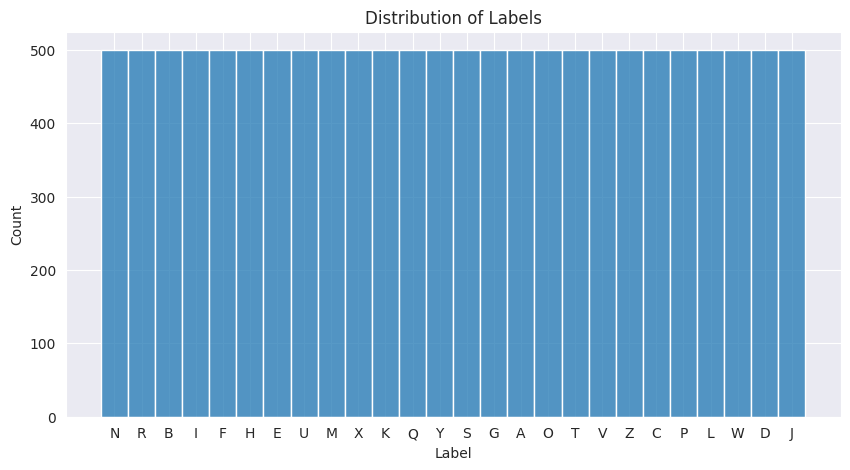

In [46]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.histplot(x='label',data=df)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

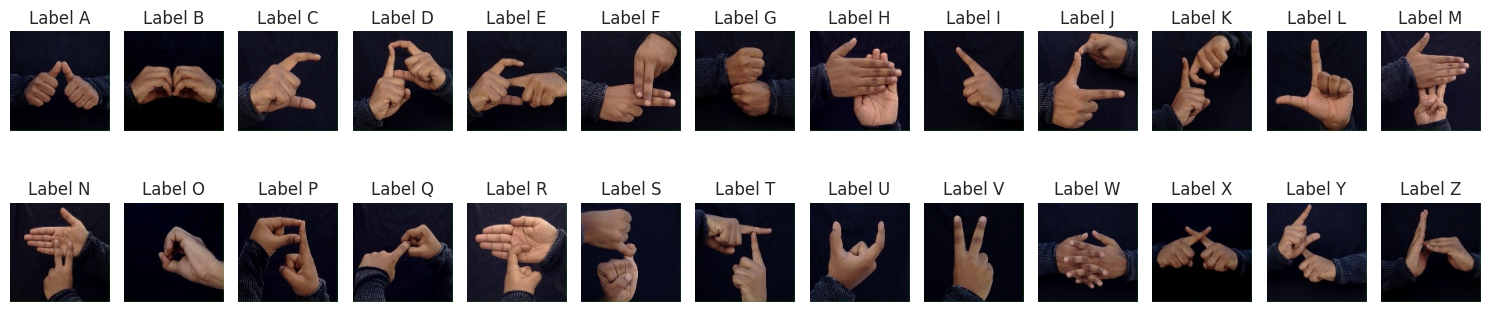

In [47]:
fig, axs = plt.subplots(2,13, figsize=(15, 4))

for i, (label, image) in enumerate(df.groupby('label').first().reset_index()[['label', 'color_image']].itertuples(index=False)):
    ax = axs[i // 13, i % 13]
    ax.imshow(image)
    ax.set_title('Label {}'.format(label))
    ax.axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()

In [48]:
images = np.array(df['color_image'])
labels = np.array(df['label'])

In [49]:
resized_images = []
for image in images:
    resized_image = image.resize((32, 32))  # Resize the image to the desired size
    resized_images.append(np.array(resized_image))
images = np.array(resized_images)

In [50]:
images = images / 255.0

In [51]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [69]:
labels

array([13, 13, 13, ...,  9,  9,  9])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [53]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=26, activation='softmax'))

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 75)        2100      
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 50)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 50)       

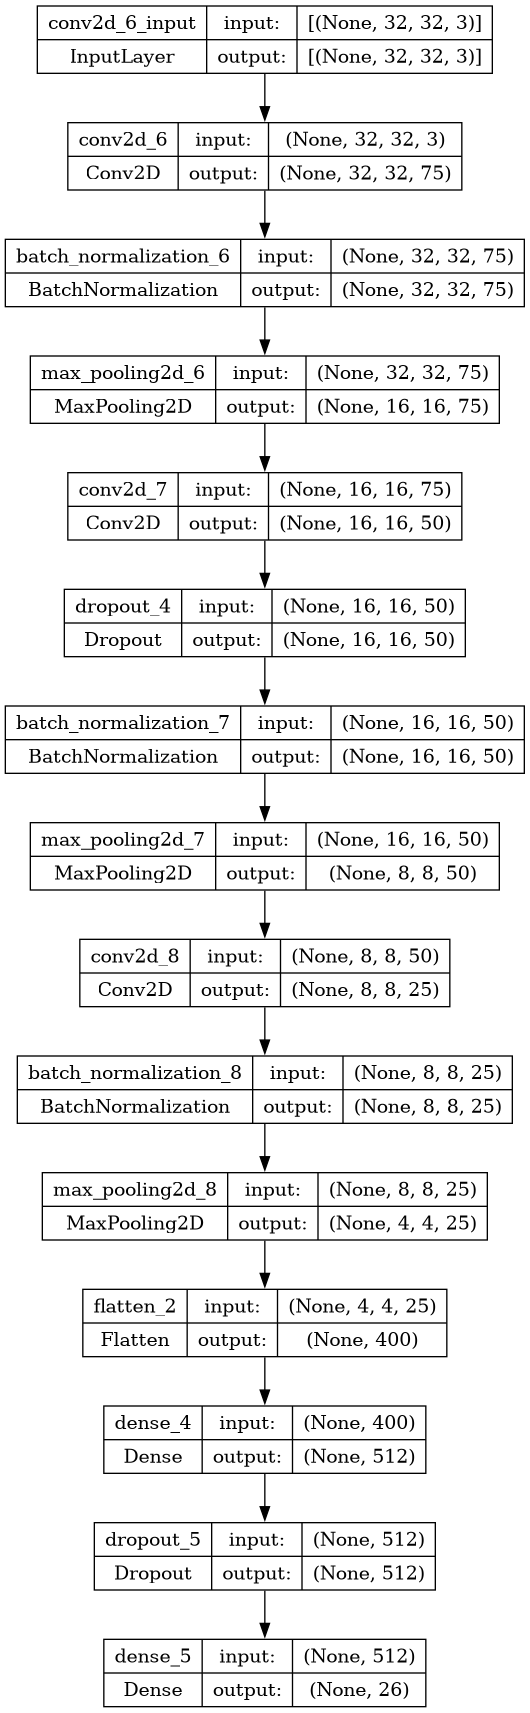

In [55]:
plot_model(model, to_file='/kaggle/working/model_architecture2.png', show_shapes=True, show_layer_names=True)

In [56]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

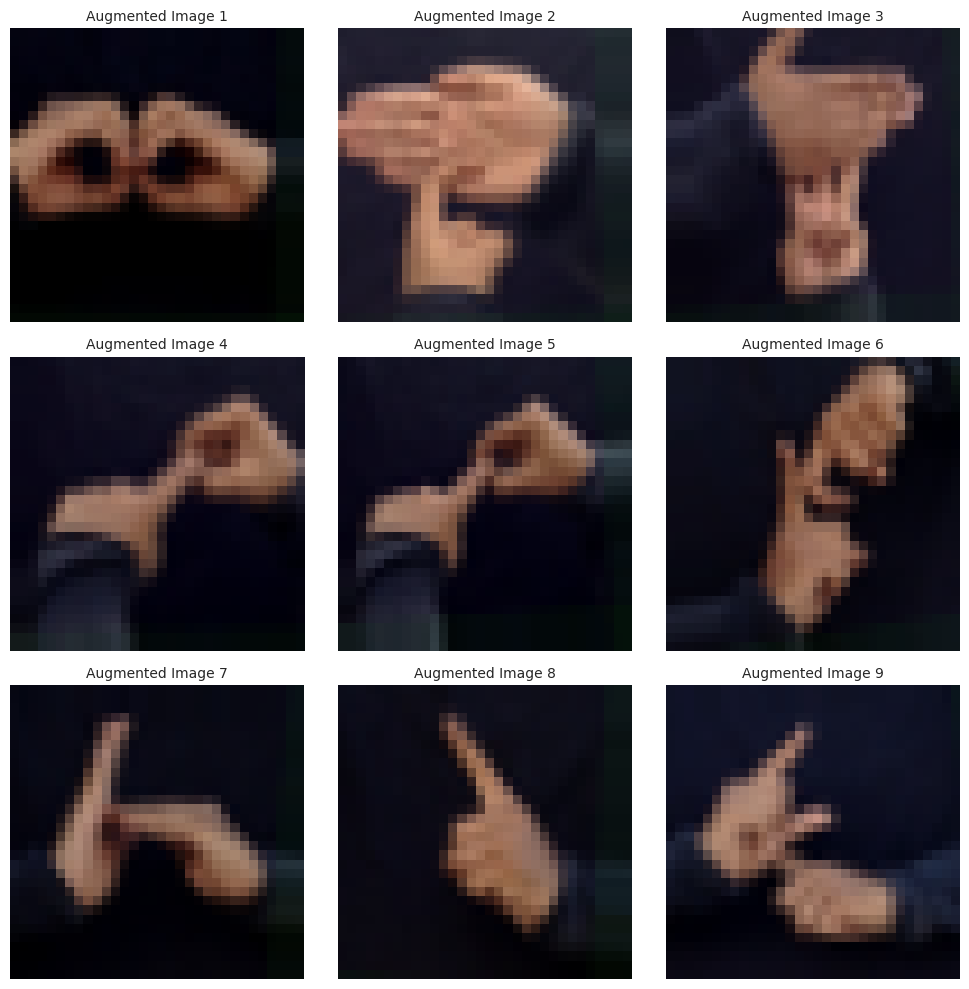

In [57]:
augmented_images = []
for X_batch, _ in datagen.flow(X_train, y_train, batch_size=9):  # Use underscore to ignore the labels
    for img in X_batch:
        augmented_images.append(img)
    break  # Generate only one batch of augmented images

# Display augmented images
plt.figure(figsize=(10, 10))
for i, image in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
    plt.title(f'Augmented Image {i + 1}', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [58]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.001)
history = model.fit(datagen.flow(X_train,y_train), epochs=25, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/25


2024-10-25 04:24:54.968194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


325/325 [==============================] - 11s 29ms/step - loss: 0.6734 - accuracy: 0.8362 - val_loss: 1.2105 - val_accuracy: 0.9773 - lr: 0.0100
Epoch 2/25
325/325 [==============================] - 9s 28ms/step - loss: 0.0886 - accuracy: 0.9832 - val_loss: 0.0152 - val_accuracy: 0.9988 - lr: 0.0100
Epoch 3/25
325/325 [==============================] - 9s 28ms/step - loss: 0.0434 - accuracy: 0.9927 - val_loss: 0.0092 - val_accuracy: 0.9942 - lr: 0.0100
Epoch 4/25
325/325 [==============================] - 9s 27ms/step - loss: 0.0329 - accuracy: 0.9927 - val_loss: 0.0027 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 5/25
325/325 [==============================] - 9s 27ms/step - loss: 0.0226 - accuracy: 0.9958 - val_loss: 0.0019 - val_accuracy: 0.9996 - lr: 0.0100
Epoch 6/25
325/325 [==============================] - 9s 27ms/step - loss: 0.0192 - accuracy: 0.9960 - val_loss: 0.0016 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 7/25
325/325 [==============================] - 9s 27ms/step - loss:

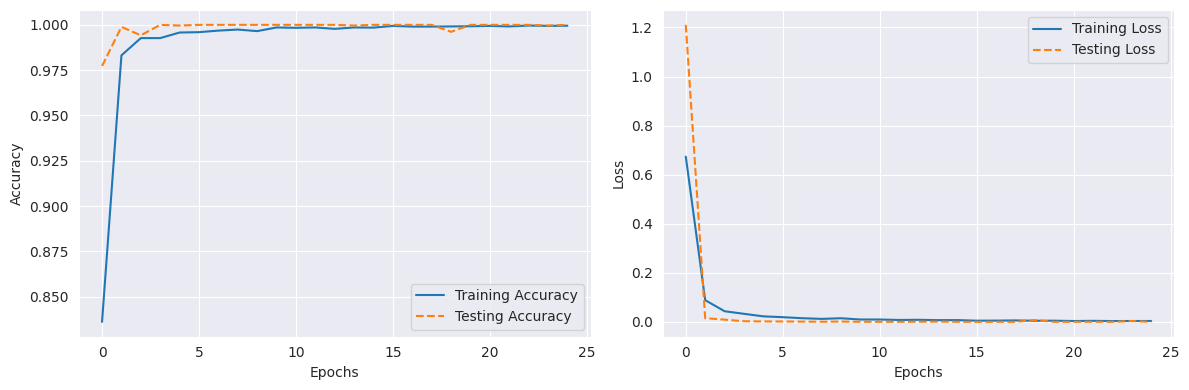

In [59]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define plot labels and styles
plot_labels = ['Accuracy', 'Loss']
plot_styles = ['-', '--']

# Plot training and testing accuracy/loss
for i, metric in enumerate(['accuracy', 'loss']):
    train_metric = history.history[metric]
    test_metric = history.history['val_' + metric]
    axs[i].plot(train_metric, label='Training ' + metric.capitalize(), linestyle=plot_styles[0])
    axs[i].plot(test_metric, label='Testing ' + metric.capitalize(), linestyle=plot_styles[1])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(plot_labels[i])
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [60]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

82/82 [==============================] - 0s 2ms/step


In [61]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

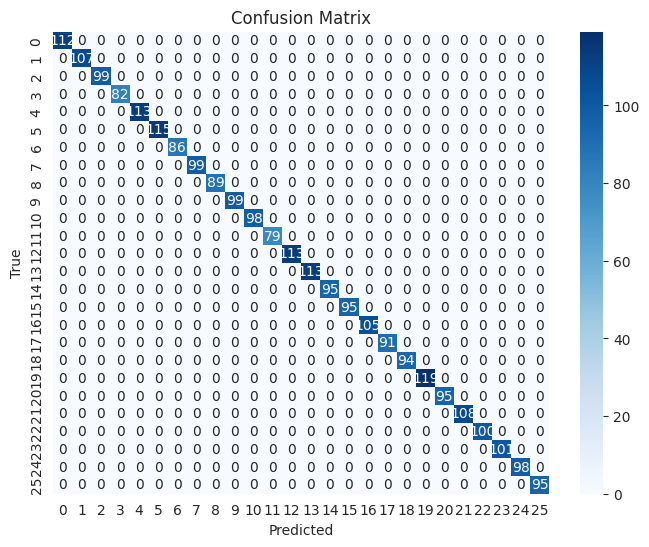

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [63]:
accuracy = model.evaluate(X_test, y_test)
print(f'validation test results - Loss: {accuracy[0]} - Accuracy: {accuracy[1]*100}%')

82/82 [==============================] - 0s 3ms/step - loss: 6.7865e-05 - accuracy: 1.0000
validation test results - Loss: 6.786522135371342e-05 - Accuracy: 100.0%


In [64]:
model.save("indianSignLanguage.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 23ms/step


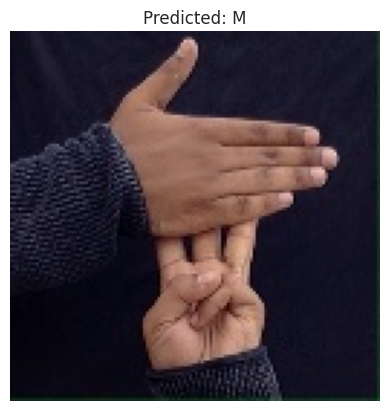

In [68]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image from the provided file path
img_path = '/kaggle/input/indian-sign-language-isl/Indian/M/1050.jpg'

# Load, resize, and preprocess the image to match the model's input shape
img = image.load_img(img_path, target_size=(32, 32))  # Replace image_height and image_width with your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image (if your model expects it)

# Predict the label for the provided image
prediction = model.predict(img_array)
predicted_label = np.argmax(prediction, axis=1)

# Decode the predicted label using the label encoder
predicted_label = label_encoder.inverse_transform(predicted_label)

# Display the provided image and predicted label
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {predicted_label[0]}", fontsize=12)
plt.axis('off')
plt.show()

In [ ]:
def preprocess_image(img):
    img = cv2.resize(img, (32, 32))  # Resize to match model input
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize the image
    return img_array


def predict_image(img_array):
    # Predict the label for the provided image
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction, axis=1)
    # Decode the predicted label using the label encoder
    predicted_label = label_encoder.inverse_transform(predicted_label)
    return predicted_label[0]

# OpenCV video capture to capture image input
cap = cv2.VideoCapture(0)  # 0 for default webcam

while True:
    ret, frame = cap.read()  # Capture frame-by-frame
    if not ret:
        print("Failed to capture image")
        break

    # Display the captured image in a window
    cv2.imshow("Press 'Space' to capture", frame)

    # Wait for the 'Space' key to be pressed for capturing the image
    if cv2.waitKey(1) & 0xFF == ord(' '):
        captured_image = frame  # Store the captured frame
        break

# Release the camera
cap.release()
cv2.destroyAllWindows()

# Preprocess the captured image for model prediction
preprocessed_image = preprocess_image(captured_image)

# Make prediction
predicted_label = predict_image(preprocessed_image)

# Display the captured image and predicted label
plt.imshow(cv2.cvtColor(captured_image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_label}", fontsize=12)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 107ms/step


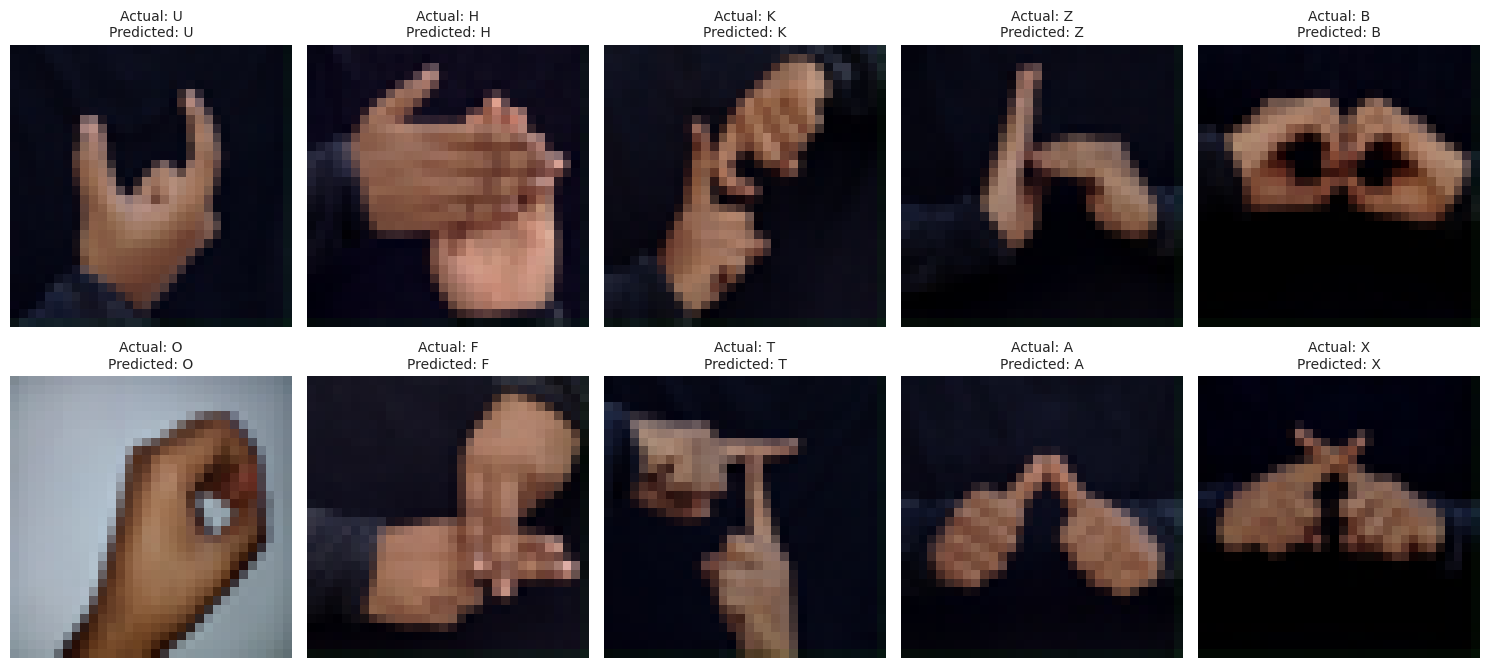

In [67]:
predictions = model.predict(X_test[:10])
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test[:10], axis=1)

# Decode labels using label encoder
predicted_labels = label_encoder.inverse_transform(predicted_labels)
actual_labels = label_encoder.inverse_transform(actual_labels)

# Display actual and predicted labels along with images for the first 10 images
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()